# **Pattern Recognition Course (Fall 2024) - Assignment #2**

**Due date**: 30th Aban 1403

**Objective**: Applying PCA and FLD techniques to the Iris dataset for dimensionality reduction and
classification.

**Dataset**: The Iris dataset contains 150 samples of iris flowers, categorized into 3 classes (setosa,
versicolor, virginica). Each sample has 4 features: sepal length, sepal width, petal length, and petal
width.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import math
from typing import Dict
from pprint import pprint

# Stage 1 : Data Acquisition


> **Q2**: Visualize the dataset.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   label         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


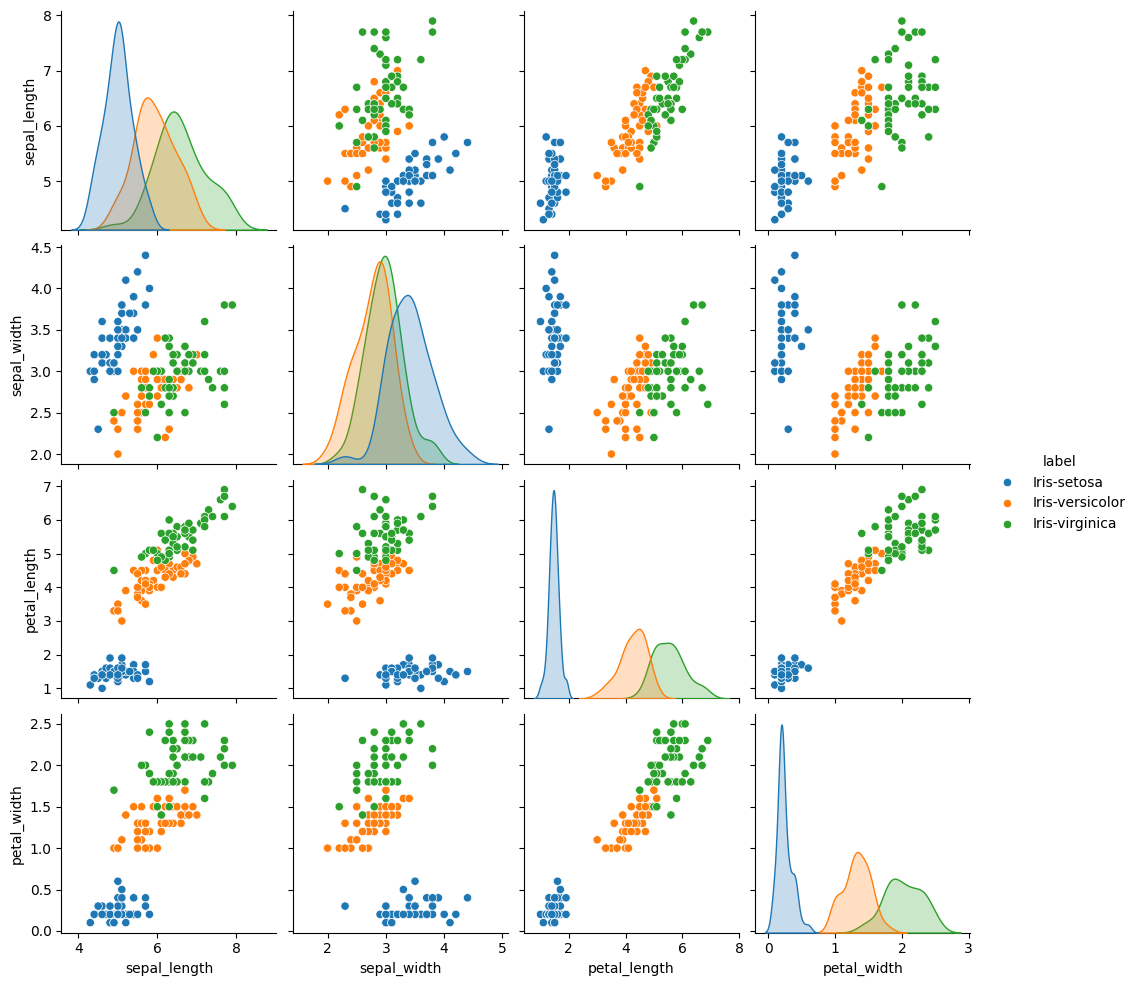

In [2]:
class_labels = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]
feat_names = ["sepal_length", "sepal_width", "petal_length", "petal_width", "label"]
df = pd.read_csv(
    "iris.csv",
    sep=",",
    names=feat_names,
)

df.info()

sns.pairplot(df, hue="label")
plt.show()

# Stage 2: Data Preprocessing


> **Q3** : Normalize the dataset.

**Why?** PCA is quite sensitive regarding the variances of the initial variables. That is, if there are large differences between the ranges of initial variables, those variables with larger ranges will dominate over those with small ranges

**Min Max Scaling** also know as normalization, Transforms features to a specific range: Typically, this range is [0, 1].

- Preserves the original shape of the distribution.
- Sensitive to outliers: Outliers can significantly affect the scaling.

**Standardization** (Z-score normalization): Transforms features to have zero mean and unit standard deviation.

- Changes the shape of the distribution.
- Less sensitive to outliers compared to min-max scaling.


In [3]:
def min_max_scaler(feat_col: pd.Series) -> float:
    min_val = feat_col.min()
    max_val = feat_col.max()

    numerator_term = feat_col - min_val
    denominator_term = max_val - min_val

    return numerator_term / denominator_term


def standardize(feat_col: pd.Series) -> float:
    mean = feat_col.mean()
    std = feat_col.std()

    return (feat_col - mean) / std


df_normalized = df.copy(deep=True)
# df_normalized[df.columns[:4]] = df[df.columns[:4]].apply(min_max_scaler)
df_normalized[df.columns[:4]] = df[df.columns[:4]].apply(standardize)

# Stage 3 : Dimensionality Reduction


In [4]:
class DimReduction:
    def __init__(self):
        self.sorted_eiglist_desc: list[tuple[float, np.ndarray]] = None
        self.projection_matrix: np.ndarray = None

    def make_structs(self):
        pass

    def eig_decomposition(
        self, mtrx: np.ndarray, scree_plot: bool = True
    ) -> list[tuple[float, np.ndarray]]:

        eigenvalues, eigenvectors = np.linalg.eig(mtrx)

        eig_list = [
            (eigval, eigvect)
            for eigval, eigvect in zip(eigenvalues.tolist(), eigenvectors.tolist())
        ]
        self.sorted_eiglist_desc = sorted(eig_list, key=lambda x: x[0], reverse=True)

        if scree_plot:
            sum_eigenvalues = eigenvalues.sum()
            var_percentage = [
                (e[0] / sum_eigenvalues) * 100 for e in self.sorted_eiglist_desc
            ]

            pc_num = np.arange(1, len(eigenvalues) + 1)
            plt.bar(pc_num, var_percentage)
            plt.plot(pc_num, var_percentage, marker="o", linestyle="-", color="red")
            plt.xlabel("Number of Components")
            plt.ylabel("percentage of variance")
            plt.title("Scree Plot")
            plt.show()

        return self.sorted_eiglist_desc

    def project(self, datapoints: np.ndarray, k: int):
        # assort eigenvectors as columns of (master) projection matrix
        self.projection_matrix = np.array([e[1] for e in self.sorted_eiglist_desc])

        # apply the transformation to the feature columns, keeping the label column unchanged
        projected_arr = np.dot(datapoints, self.projection_matrix[:, :k])
        projected_df_dict = {f"PC{i+1}": projected_arr[:, i] for i in range(k)}
        projected_df_dict.update({"label": df["label"]})
        projected_df = pd.DataFrame(projected_df_dict)

        return projected_df

## PCA


In [ ]:
class PCA(DimReduction):
    def make_structs(self, df: pd.DataFrame) -> np.ndarray:
        return df[df.columns[:4]].cov().values


pca = PCA()

> **Q4.1:** Compute the Covariance matrix

**why?** Because sometimes, variables are highly correlated in such a way that they contain redundant information. So, in order to identify these correlations, we compute the covariance matrix.

**How to interpret?** The sign of the covariance that matters:

- If (+) then: the two variables increase or decrease together (correlated)
- If (-) then: one increases when the other decreases (Inversely correlated)


In [ ]:
cov = pca.make_structs(df=df_normalized)
print(cov)

              sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.109369      0.871754     0.817954
sepal_width      -0.109369     1.000000     -0.420516    -0.356544
petal_length      0.871754    -0.420516      1.000000     0.962757
petal_width       0.817954    -0.356544      0.962757     1.000000


> **Q4.2:** Plot the Eigenvalues of the Covariance matrix in descending order

The **eigen decomposition** is performed on the covariance matrix to obtain the eigenvalues and eigenvectors.

1.  Eigenvalues represent coefficients attached to eigenvectors, which give the amount of variance carried in each Principal Component.
2.  Eigenvectors represent the directions or axes of maximum variance in the data.

**How to visualize?** In order to compute the percentage of variance (information) accounted for by each component, we divide the eigenvalue of each component by the sum of eigenvalues and plot the data on a scree plot.


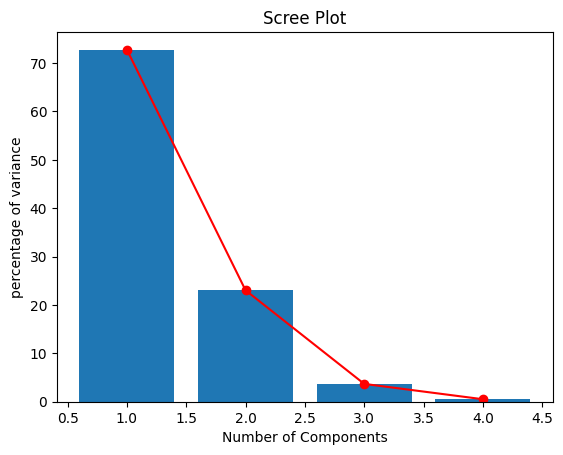

[(2.9108180837520563,
  [0.5223716204076606,
   -0.37231836334996876,
   -0.7210168090620422,
   0.26199558689998087]),
 (0.9212209307072229,
  [-0.2633549153139397,
   -0.9255564941472947,
   0.24203287721394112,
   -0.12413481006268233]),
 (0.14735327830509587,
  [0.5812540055976475,
   -0.02109477684124587,
   0.1408922584875416,
   -0.801154269079924]),
 (0.02060770723562511,
  [0.5656110498826492,
   -0.06541576907892808,
   0.6338014033558239,
   0.5235462716041909])]


In [ ]:
pca.eig_decomposition(mtrx=cov)
pprint(pca.sorted_eiglist_desc)

> **Q5:** Choose an appropriate number of features based on the Eigenvalue plot

**Select the principal components**: The eigenvectors associated with the highest eigenvalues are selected as the principal components.

_These components capture the most significant patterns or variations in the data._


> **Q6**: Project the data into the new subspace

**Project the data onto the principal components**: The original data is projected onto the selected principal components to obtain the transformed lower-dimensional representation. Each data point is represented by its coordinates along the principal components.


array([[ 0.52237162, -0.37231836, -0.72101681,  0.26199559],
       [-0.26335492, -0.92555649,  0.24203288, -0.12413481],
       [ 0.58125401, -0.02109478,  0.14089226, -0.80115427],
       [ 0.56561105, -0.06541577,  0.6338014 ,  0.52354627]])


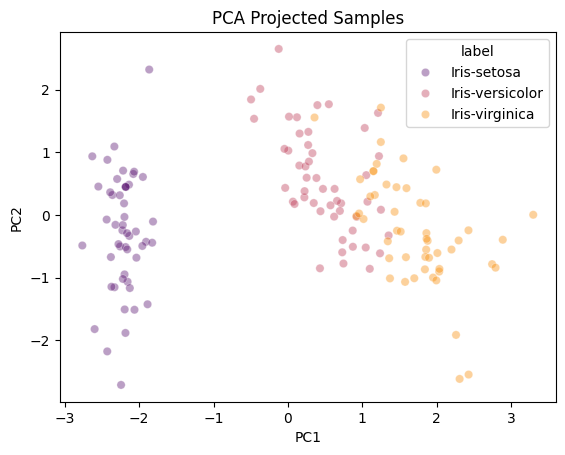

In [26]:
k_pca = 2
pca_projected_df = pca.project(datapoints=df_normalized.values[:, :4], k=k_pca)
pprint(pca.projection_matrix)
sns.scatterplot(
    x="PC1", y="PC2", hue="label", data=pca_projected_df, palette="inferno", alpha=0.4
)
plt.title("PCA Projected Samples")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

## FLD


In [42]:
class FLD(DimReduction):
    def make_structs(self, df: pd.DataFrame, n_feat: int):
        sw = np.zeros((4, 4))
        sb = np.zeros((4, 4))

        # rows: as many as distinct classes, columns: as many as features
        class_means = df.groupby("label").mean()
        overall_mean = df[df.columns[:n_feat]].mean()

        for c_label, c_mean in class_means.iterrows():
            diff = c_mean - overall_mean
            sb += np.outer(diff, diff.T) * len(df[df["label"] == c_label])

        for c in df["label"].unique():
            class_df = df[df["label"] == c]
            class_cov = np.cov(class_df[class_df.columns[:4]].values.T)
            sw += class_cov

        if np.linalg.det(sw) == 0:
            raise ValueError(
                "sw is singular and cannot be inverted! \n Double check the inputs!"
            )
        m = np.linalg.inv(sw).dot(sb)

        return m, sw, sb, class_means, overall_mean


fld = FLD()


In [43]:
m, sw, sb, class_means, overall_mean = fld.make_structs(df=df_normalized, n_feat=4)

print(">>> mean per class:")
pprint(class_means)
print(">>> mean of means:")
pprint(overall_mean)
print(">>> Sw :")
pprint(sw)
print(">>> Sb :")
pprint(sb)

>>> mean per class:
                 sepal_length  sepal_width  petal_length  petal_width
label                                                                
Iris-setosa         -1.011191     0.839494     -1.300521    -1.250938
Iris-versicolor      0.111907    -0.654990      0.284135     0.166850
Iris-virginica       0.899284    -0.184504      1.016387     1.084088
>>> mean of means:
sepal_length   -5.684342e-16
sepal_width    -6.158037e-16
petal_length    1.894781e-16
petal_width    -1.894781e-16
dtype: float64
>>> Sw :
array([[1.15944584, 0.77774397, 0.34381041, 0.18264238],
       [0.77774397, 1.8491788 , 0.2166079 , 0.30301824],
       [0.34381041, 0.2166079 , 0.17843822, 0.09477983],
       [0.18264238, 0.30301824, 0.09477983, 0.2163969 ]])
>>> Sb :
array([[ 92.18715388, -54.40547263, 113.04465941, 112.92561462],
       [-54.40547263,  58.39023868, -73.27068562, -67.97296293],
       [113.04465941, -73.27068562, 140.25652706, 138.80659582],
       [112.92561462, -67.97296293, 13

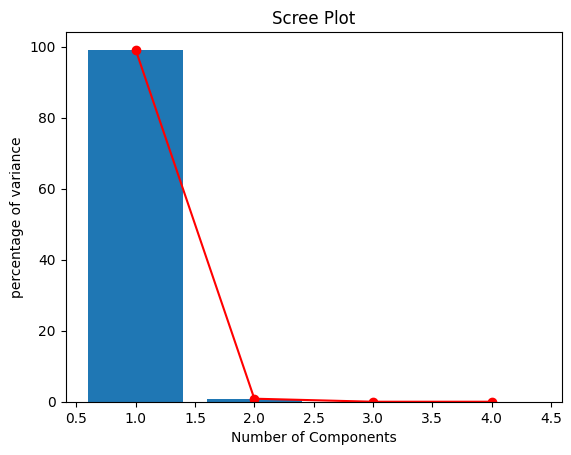

[(1581.3259321867629,
  [-0.14977569639015254,
   0.009529304239959208,
   0.24974028424423353,
   0.19889217085061672]),
 (13.60077632816231,
  [-0.14817298129141565,
   0.3271933649754191,
   0.11184987067222858,
   -0.17008311793363798]),
 (-4.388219547776456e-14,
  [0.851121894975106,
   -0.5748203423144747,
   0.6006237732758137,
   -0.7932549048259937]),
 (-3.0607594551870756e-13,
  [0.48083628012042007,
   0.7499568443172147,
   -0.751245951624459,
   0.5497820416654268])]

In [44]:
fld.eig_decomposition(mtrx=m)

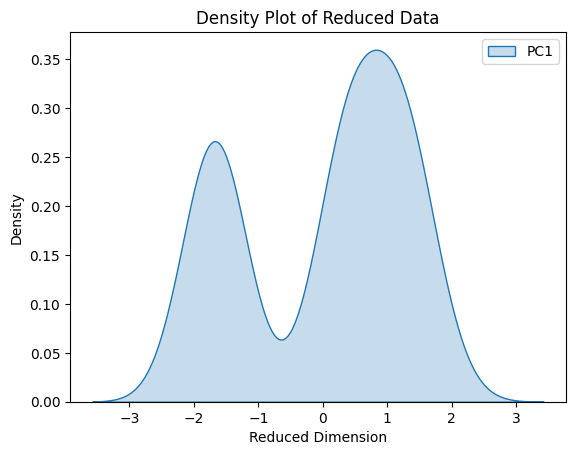

In [45]:
k_fld = 1

fld_projected_df = fld.project(datapoints=df_normalized.values[:, :4], k=k_fld)
if k_fld == 2:
    sns.scatterplot(
        x="PC1",
        y="PC2",
        hue="label",
        data=fld_projected_df,
        palette="inferno",
        alpha=0.4,
    )
    plt.title("FLD Projected Samples")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.show()
if k_fld == 1:
    sns.kdeplot(fld_projected_df, fill=True)
    plt.xlabel("Reduced Dimension")
    plt.ylabel("Density")
    plt.title("Density Plot of Reduced Data")
    plt.show()

# Stage 4: Model Building


**Q7.1:** Apply a Bayes classifier with a Gaussian parametric estimate of pdfs


In [ ]:
def df_splitter(df: pd.DataFrame, test_frac: float):
    if test_frac >= 1:
        raise ValueError("Test Ratio must be less than zero")

    test_df = df.sample(frac=test_frac)
    train_df = df.drop(test_df.index)

    return train_df, test_df


class NBGaussian:
    def __init__(self, inv_cov: np.ndarray, det_cov: int, class_mean: np.ndarray):
        self.inv_cov = inv_cov
        self.det_cov = det_cov
        self.class_mean = class_mean
        self.term_1 = 0.5 * math.log(det_cov, math.e)

    def g(self, sample: np.ndarray) -> float:
        diff = sample - self.class_mean
        term_2 = 0.5 * np.dot(diff.T, np.dot(self.inv_cov, diff))

        return -(self.term_1 + term_2)


class BayesClassifier:
    def __init__(self):
        self.class_discriminator_dict = {}

    def fit(self, train_df: pd.Series, k: int) -> Dict[str, NBGaussian]:
        for c in train_df["label"].unique():
            class_df = train_df[train_df["label"] == c]
            # class_cov = np.cov(class_df[class_df.columns[:k]].values.T)
            class_cov = class_df[class_df.columns[:k]].cov().values
            class_mean = class_df[class_df.columns[:k]].values.mean()

            class_discriminator = NBGaussian(
                inv_cov=np.linalg.inv(class_cov),
                det_cov=np.linalg.det(class_cov),
                class_mean=class_mean,
            )

            self.class_discriminator_dict[c] = class_discriminator

        return self.class_discriminator_dict

    def _row_predictor(self, sample: pd.Series) -> str:
        chances = {}
        for label, label_f in self.class_discriminator_dict.items():
            g = label_f.g(sample.to_numpy())
            chances[g] = label
        return chances.get(max(chances.keys()))

    def predict(self, test_df: pd.DataFrame, k: int) -> pd.DataFrame:
        if not self.class_discriminator_dict:
            raise ValueError("model is not fitted yet.")

        prediction_df = test_df.iloc[:, :k].apply(
            lambda row: self._row_predictor(row), axis=1
        )
        prediction_df.rename("Result")  # Rename the column
        return prediction_df


## PCA


In [36]:
pca_train_df, pca_test_df = df_splitter(df=pca_projected_df, test_frac=0.3)
pca_clf = BayesClassifier()
pca_clf.fit(train_df=pca_train_df, k=2)
pca_prediction_df = pca_clf.predict(test_df=pca_test_df, k=2)

## FLD


In [46]:
fld_train_df, fld_test_df = df_splitter(df=fld_projected_df, test_frac=0.3)
fld_clf = BayesClassifier()
fld_clf.fit(train_df=fld_train_df, k=k_fld)
fld_prediction_df = fld_clf.predict(test_df=fld_test_df, k=k_fld)

# Stage 5: Evaluation


## Auxiliary Tools

In [ ]:
def accuracy_score(target_labels: np.ndarray, predicted_labels:np.ndarray):
    correct_predictions = np.sum(target_labels == predicted_labels)
    total_predictions = len(target_labels)
    accuracy = correct_predictions / total_predictions

    return accuracy

def visualize_accuracy(cm: np.ndarray, technique_title: str, accuracy: float):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Plot the confusion matrix on the first subplot
    sns.heatmap(
        ax=ax1,  # Pass the subplot ax1 to sns.heatmap
        data=cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")
    ax1.set_title(f"{technique_title} Confusion Matrix")

    # Calculate accuracy and error rate
    accuracy_percentage = accuracy * 100
    error_rate_percentage = (1 - accuracy) * 100

    # Create the pie chart on the second subplot
    labels = ["Accuracy", "Error Rate"]
    sizes = [accuracy_percentage, error_rate_percentage]
    colors = ["#66cdaa", "#f08080"]
    explode = (0.1, 0)

    ax2.pie(
        sizes,
        explode=explode,
        labels=labels,
        colors=colors,
        autopct="%1.1f%%",  # Display percentage with one decimal place
        shadow=True,
        startangle=140,
    )
    ax2.set_title("Accuracy vs. Error Rate")

    plt.tight_layout()
    plt.show()

## PCA


**Q7.2:** report the accuracy


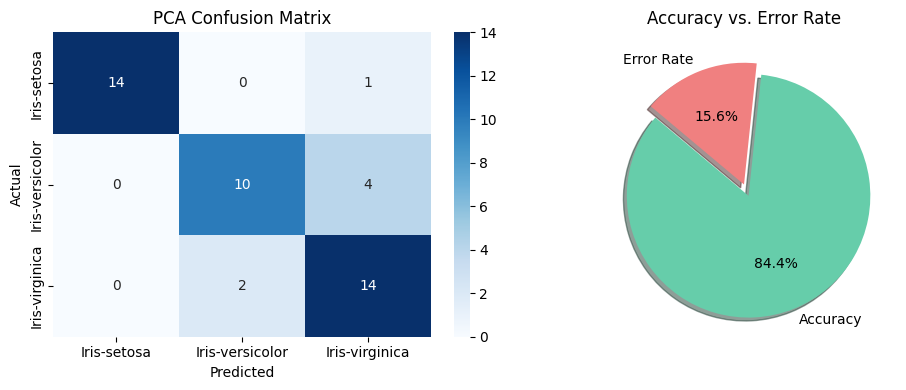

In [41]:
pca_cm = confusion_matrix(
    pca_test_df.values[:,k_pca], pca_prediction_df.values[:], labels=class_labels
)

pca_accuracy = accuracy_score(
    target_labels=pca_test_df.values[:, k_pca], predicted_labels=pca_prediction_df.values
)
visualize_accuracy(cm=pca_cm, technique_title="PCA", accuracy=pca_accuracy)


## FLD


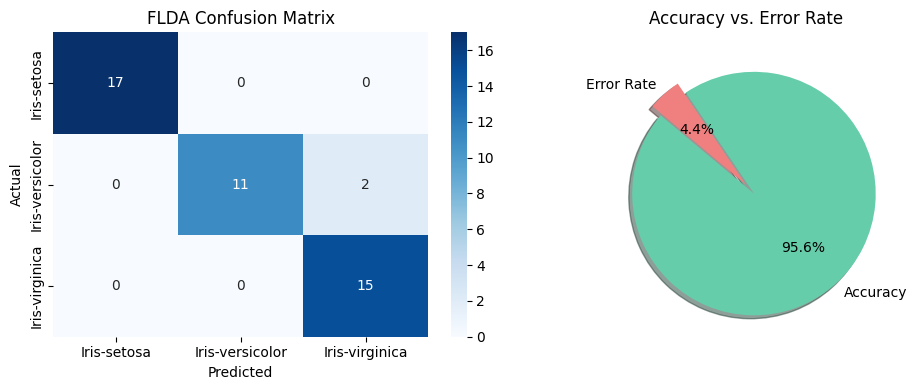

In [47]:
fld_cm = confusion_matrix(
    fld_test_df.iloc[:, k_fld], fld_prediction_df.values, labels=class_labels
)

fld_accuracy = accuracy_score(
    target_labels=fld_test_df.values[:, k_fld], predicted_labels=fld_prediction_df.values
)
visualize_accuracy(cm=fld_cm, technique_title="FLDA", accuracy=fld_accuracy)
